In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('adult.csv')
print('shape',df.shape)
df.head(10)

shape (48842, 15)


,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K
5,34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K
6,29,?,227026,HS-grad,9,Never-married,?,Unmarried,Black,Male,0,0,40,United-States,<=50K
7,63,Self-emp-not-inc,104626,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,3103,0,32,United-States,>50K
8,24,Private,369667,Some-college,10,Never-married,Other-service,Unmarried,White,Female,0,0,40,United-States,<=50K
9,55,Private,104996,7th-8th,4,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,10,United-States,<=50K


In [3]:
#Dropping a few features that won't help in the story

df=df.drop(columns=['fnlwgt','educational-num','relationship','gender','capital-gain','capital-loss'])

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       48842 non-null  object
 2   education       48842 non-null  object
 3   marital-status  48842 non-null  object
 4   occupation      48842 non-null  object
 5   race            48842 non-null  object
 6   hours-per-week  48842 non-null  int64 
 7   native-country  48842 non-null  object
 8   income          48842 non-null  object
dtypes: int64(2), object(7)
memory usage: 3.4+ MB


In [5]:
#There are no null values, but the '?' should definately be counted as null.
#Replace '?' with null and then remove

df = df.replace('?', np.NaN).dropna()

In [6]:
df.isnull().sum()

age               0
workclass         0
education         0
marital-status    0
occupation        0
race              0
hours-per-week    0
native-country    0
income            0
dtype: int64

In [7]:
#Problem: Getting a livable wage over 50k without much education


#story I want to tell: earning a livable wage over 50k is possible even without higher education and having a degree does not guarantee a good salary


In [8]:
below_50k = df[df.income=='<=50K']
over_50k = df[df.income=='>50K']

In [9]:
def cdf(x, plot=True,ylab='CDF', *args, **kwargs):
    x, y = sorted(x), np.arange(len(x)) / len(x)
    return plt.plot(x, y, *args, **kwargs)  if plot else (x, y), plt.ylabel('CDF') 
         

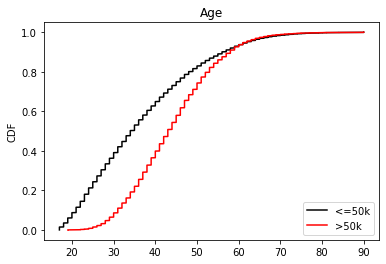

In [10]:


cdf(below_50k.age,label='<=50k',c='k')
cdf(over_50k.age,label='>50k',c='r')
plt.title('Age')
plt.legend(loc='lower right')

In [11]:
#The most variance occurs between age 17 and around 60.  So let's look at those age range only
#Then create groups for ages

df= df[df.age<60]

bins= [17,20,25,30,35,40,45,50,55,61]
labels = ['17-19','20-24','25-29','30-34','35-39','40-44', '45-49','50-54','55-60']
df['AgeGroup'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)

In [12]:
#There are much outliers in the hour of week. 

df['hours-per-week'].sort_values().to_frame()

,hours-per-week
9076,1
10447,1
36031,1
16470,1
27732,1
...,...
35422,99
26547,99
45468,99
31461,99


In [13]:
#I'll only look at hours between 20-60

df=df[(df['hours-per-week']>=20)&(df['hours-per-week']<=60)]

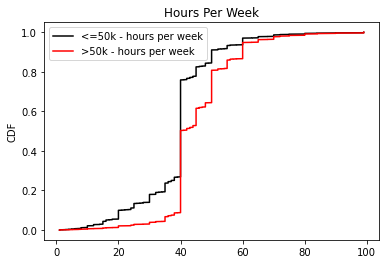

In [14]:
cdf(below_50k['hours-per-week'],c='k',label='<=50k - hours per week')
cdf(over_50k['hours-per-week'],c='r',label = '>50k - hours per week')
plt.title('Hours Per Week')
plt.legend()

In [15]:
#Replace all levels under HS grad as 'below_HS'

df = df.replace(['11th','10th','5th-6th','7th-8th', '9th','12th', '1st-4th', 'Preschool','HS_drop'],
           ['below_HS','below_HS','below_HS','below_HS','below_HS','below_HS','below_HS','below_HS','below_HS'])

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 <a list of 9 Text major ticklabel objects>)

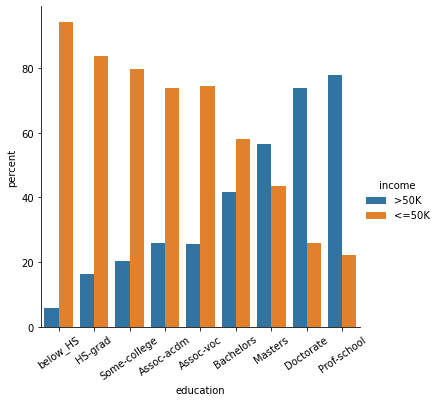

In [16]:
#First of all, lets look at education, because only people with the best education get a good salary (above 50k) right?

edu = ['below_HS','HS-grad','Some-college',
       'Assoc-acdm','Assoc-voc','Bachelors','Masters', 'Doctorate','Prof-school']

x,y = 'education', 'income'

df.groupby(x)[y].value_counts(normalize=True).sort_values().mul(100).rename('percent').reset_index().pipe((sns.catplot,'data'), x=x,y='percent',hue=y,kind='bar',order=edu)

plt.xticks(rotation=35)

In [17]:
#The data does show that as you gain a better degree, you do end up getting a better salary
#But lets keep digging. That cant be the only reason someone can get a livable wage. Lets look at marital status

In [18]:
marital = ['Never-married','Separated','Divorced','Married-spouse-absent','Married-AF-spouse','Married-civ-spouse','Widowed']

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text major ticklabel objects>)

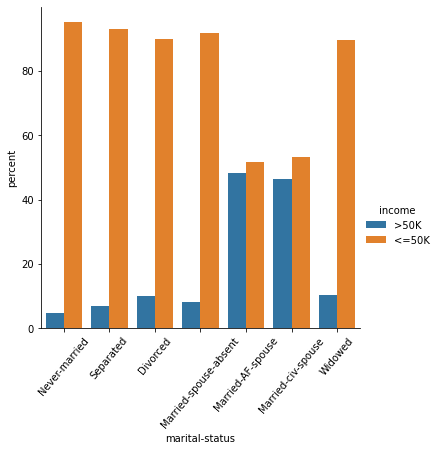

In [19]:
x,y = 'marital-status', 'income'

df.groupby(x)[y].value_counts(normalize=True).sort_values().mul(100).rename('percent').reset_index().pipe((sns.catplot,'data'), x=x,y='percent',hue=y,kind='bar',order = marital)
plt.xticks(rotation=50)


If you count Married with the spouse absent as being unmarried, then being married and staying married greatly increase your chances of having a better income. Whereas if a person is not currently married, their chances of having a better income exponetially decreases.  Surprisingly, becoming widowed has the similair affect.  

In [20]:
#But how many of those Married/divorced people have an education?
#How many of those divored people have an education? 



In [21]:
married =['Married-AF-spouse','Married-civ-spouse']
not_married = ['Never-married', 'Widowed', 'Separated',
       'Divorced', 'Married-spouse-absent']

df_married =df[df['marital-status'].isin(married)]
df_not_married =df[df['marital-status'].isin(not_married)]

df_married_over_50k = df_married[df_married.income=='>50K']
df_married_under_50k = df_married[df_married.income=='<=50K']

df_not_married_over_50k = df_not_married[df_not_married.income=='>50K']
df_not_married_under_50k = df_not_married[df_not_married.income=='<=50K']

In [22]:
#Create fature for being married, making over/under 50k, and either having lower or higher education

HS_Deg = ['HS_drop', 'HS-grad','Some-college','below_HS']


df_married_over_50k['lower_higher_edu']=df_married_over_50k['education'].map(lambda x:'HS_Deg' if x in HS_Deg else 'Assoc_Or_Higher')
df_married_under_50k['lower_higher_edu']=df_married_under_50k['education'].map(lambda x:'HS_Deg' if x in HS_Deg else 'Assoc_Or_Higher')

df_not_married_over_50k['lower_higher_edu']=df_not_married_over_50k['education'].map(lambda x:'HS_Deg' if x in HS_Deg else 'Assoc_Or_Higher')
df_not_married_under_50k['lower_higher_edu']=df_not_married_under_50k['education'].map(lambda x:'HS_Deg' if x in HS_Deg else 'Assoc_Or_Higher')

<ipython-input-22-88eaa235ffe6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_married_over_50k['lower_higher_edu']=df_married_over_50k['education'].map(lambda x:'HS_Deg' if x in HS_Deg else 'Assoc_Or_Higher')
<ipython-input-22-88eaa235ffe6>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_married_under_50k['lower_higher_edu']=df_married_under_50k['education'].map(lambda x:'HS_Deg' if x in HS_Deg else 'Assoc_Or_Higher')
<ipython-input-22-88eaa235ffe6>:9: SettingWithCopyWarning: 
A value is trying to

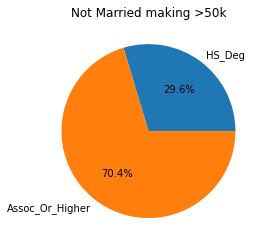

In [23]:
#While not married, you'll have over two times the chances to make over 50k only if you have some form of higher education

plt.pie(df_not_married_over_50k['lower_higher_edu'].value_counts().sort_values(),labels=df_not_married_over_50k['lower_higher_edu'].value_counts().sort_values().index,autopct='%1.1f%%'
       )
plt.title('Not Married making >50k')

plt.show()

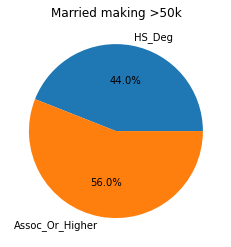

In [24]:
#But just by remaining married, your chances increases greatly and is almost the same as those who have a higher education


plt.pie(df_married_over_50k['lower_higher_edu'].value_counts().sort_values(),labels=df_married_over_50k['lower_higher_edu'].value_counts().sort_values().index,autopct='%1.1f%%'
       )
plt.title('Married making >50k')



plt.show()

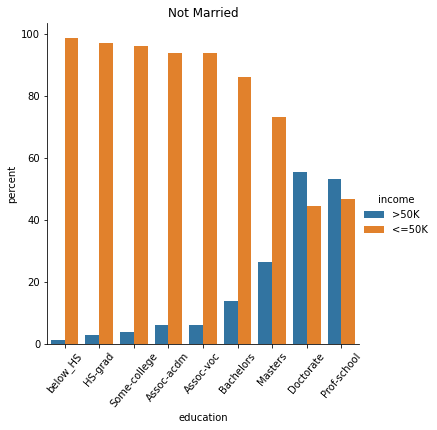

In [25]:
x,y = 'education', 'income'

df_not_married.groupby(x)[y].value_counts(normalize=True).sort_values().mul(100).rename('percent').reset_index().pipe((sns.catplot,'data'), x=x,y='percent',hue=y,kind='bar',order=edu)
plt.xticks(rotation=50)
plt.title('Not Married')

plt.show()

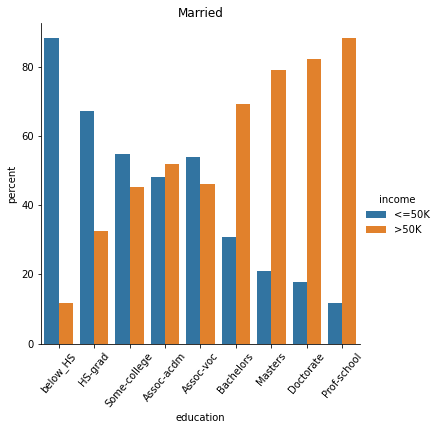

In [26]:
x,y = 'education', 'income'

df_married.groupby(x)[y].value_counts(normalize=True).sort_values().mul(100).rename('percent').reset_index().pipe((sns.catplot,'data'), x=x,y='percent',hue=y,kind='bar',order=edu)
plt.xticks(rotation=50)
plt.title('Married')
plt.show()



While not married, you only have equal or greater chances of having a salary over 50k if you also have a Doctorate or Prof school degree! 

But if you're married, you have equal chances of getting that salary with only some college degree

In [27]:
df.head()

,age,workclass,education,marital-status,occupation,race,hours-per-week,native-country,income,AgeGroup
0,25,Private,below_HS,Never-married,Machine-op-inspct,Black,40,United-States,<=50K,25-29
1,38,Private,HS-grad,Married-civ-spouse,Farming-fishing,White,50,United-States,<=50K,35-39
2,28,Local-gov,Assoc-acdm,Married-civ-spouse,Protective-serv,White,40,United-States,>50K,25-29
3,44,Private,Some-college,Married-civ-spouse,Machine-op-inspct,Black,40,United-States,>50K,40-44
5,34,Private,below_HS,Never-married,Other-service,White,30,United-States,<=50K,30-34


In [28]:
#So being married helps, what else could one do to improve their chances of getting a livable wage? 
#Lets look at age





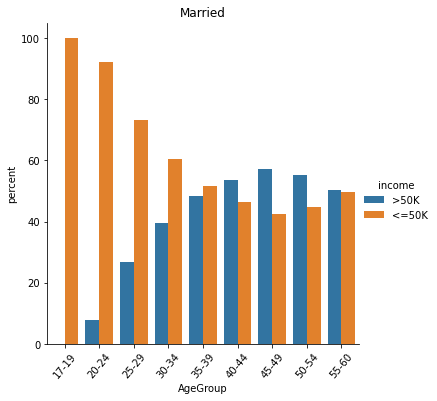

In [33]:
x,y = 'AgeGroup', 'income'

df_married.groupby(x)[y].value_counts(normalize=True).sort_values().mul(100).rename('percent').reset_index().pipe((sns.catplot,'data'), x=x,y='percent',hue=y,kind='bar')
plt.xticks(rotation=50)
plt.title('Married')
plt.show()

In [35]:
df.head()

,age,workclass,education,marital-status,occupation,race,hours-per-week,native-country,income,AgeGroup
0,25,Private,below_HS,Never-married,Machine-op-inspct,Black,40,United-States,<=50K,25-29
1,38,Private,HS-grad,Married-civ-spouse,Farming-fishing,White,50,United-States,<=50K,35-39
2,28,Local-gov,Assoc-acdm,Married-civ-spouse,Protective-serv,White,40,United-States,>50K,25-29
3,44,Private,Some-college,Married-civ-spouse,Machine-op-inspct,Black,40,United-States,>50K,40-44
5,34,Private,below_HS,Never-married,Other-service,White,30,United-States,<=50K,30-34


In [50]:
#I want to answer the question

#What occupation should I do if I was married, no college degree? 

df_married['HS_or_Higher'] = df_married['education'].map(lambda x:'HS_Deg' if x in HS_Deg else 'Assoc_Or_Higher')

df_married_HS = df_married[df_married['HS_or_Higher']=='HS_Deg']

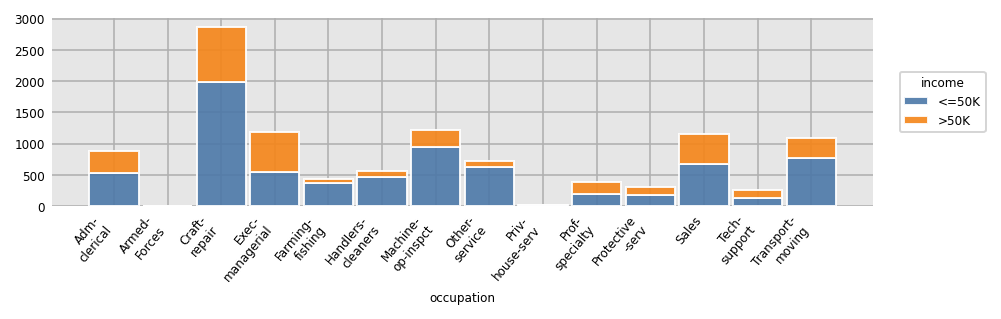

In [73]:
#So being married helps, what else could one do to improve their chances of getting a livable wage? 
#Lets look at occupation

import dexplot as dxp

dxp.count('occupation', data=df_married_HS, split='income',x_rot=50,stacked=True)




There is no one outstanding occupation where one will have much higher odds of getting a salary over 50k.  But Craft-repair does have the most available jobs and a good portion of if does pay over 50k.  Exec-managerial has the highest odds of income over 50k in it's own field.  Sales seems to be pretty good too.  